In [1]:
import numpy as np
from sympy import symbols
from scipy.signal import find_peaks
from scipy.linalg import eigvalsh_tridiagonal
from mpmath import mp
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import subprocess
from contextlib import redirect_stdout

In [2]:
#Set up mpmath here
mp.prec = 200 # Sets the precision of calculations in bits
print(mp)

Mpmath settings:
  mp.prec = 200               [default: 53]
  mp.dps = 59                 [default: 15]
  mp.trap_complex = False     [default: False]


In [3]:
def solve(problem, Es):
    vals = []
    for E in Es:
        vals.append(problem.solve(E))
    return np.array(vals)

def solveTISE(xmin, xmax, N, potential, Emax):
    """
    Solve H = p^2 + V(x).
    """
    p = np.linspace(xmin, xmax, num=N)
    step = p[1] - p[0]
    d = 2 * np.ones(N) / step ** 2 + potential(p)
    e = -np.ones(N - 1) / step ** 2
    spectrum = eigvalsh_tridiagonal(d, e, select='v', select_range=[-1, Emax])
    return spectrum

def solveSUSYTISE(xmin, xmax, N, W2, Wdiff, Emax):
    """
    Solve H = p^2 + W^2(x) - Wdiff \sigma_3.
    """
    p = np.linspace(xmin, xmax, num=N)
    Wsq = W2(p)
    Wd = Wdiff(p)
    step = p[1] - p[0]
    d = 2 * np.ones(2 * N) / step ** 2 + np.hstack([Wsq - Wd, Wsq + Wd])
    e = -np.ones(2 * N - 1) / step ** 2
    spectrum = eigvalsh_tridiagonal(d, e, select='v', select_range=[-1, Emax])
    return spectrum

In [4]:
class SDPAWrapper:
    def __init__(self):
        self.status = None
        self.oval = None
        self.xval = None
    
    def run(self, file='aho'):
        args = ['sdpa_gmp',f'{file}.dat',f'{file}.result']
        subprocess.run(args, stdout=subprocess.DEVNULL)
        with open(f'{file}.result','r') as f:
            lines = f.readlines()
            for lpos, line in enumerate(lines):
                if line.startswith('phase.value'):
                    self.status = line.split(' ')[2]
                if line.startswith('objValPrimal'):
                    self.oval = np.double(line.split(' ')[2])
                if line.startswith('xVec'):
                    self.xval = np.array(lines[lpos + 1][1:-2].split(','), dtype=np.double)

# You do not need to create any more instances of this class
# SDPARunObject runs the data file and stores the status, objective value, and the values of the optimization variables
SDPARunObject = SDPAWrapper()

In [5]:
class Problem:
    def __init__(self, K, problem_name):
        self._K = K
        self._name = problem_name
        self._basis = None
        self._freevars = None
        self._E = symbols('E')

    def _initialize_basis(self):
        raise NotImplementedError

    def _implement_recursion(self):
        raise NotImplementedError

    def _get_free_variables(self):
        raise NotImplementedError

    def initialize_problem(self):
        self._initialize_basis()
        self._implement_recursion()
        self._get_free_variables()


In [6]:
class HankelProblem(Problem):
    def __init__(self, K, problem_name):
        super().__init__(K, problem_name)
        self._internal_matrix = None
    
    def _get_free_variables(self):
        self._freevars = set()
        for v1 in self._basis:
            for v2 in v1:
                if hasattr(v2, 'free_symbols'):
                    self._freevars |= v2.free_symbols
        # The energy is not a free variable
        self._freevars.discard(self._E)
        self._freevars = list(self._freevars)
    
    def _generate_internal_matrix_structure(self):
        raise NotImplementedError

    def initialize_problem(self):
        super().initialize_problem()
        self._generate_internal_matrix_structure()
        self._generate_unsubstituted_sdpa_matrices()

    def _generate_unsubstituted_sdpa_matrices(self):
        # [F0] + [F1,...,Fc] + [t]
        M = self._internal_matrix
        self._Fs = [np.zeros_like(M)] + [np.zeros_like(M) for _ in range(len(self._freevars))] + [np.eye(M.shape[0])]
        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                term = M[i, j]
                if hasattr(term, 'expand'):
                    term = term.expand()
                    for p, var in enumerate(self._freevars, 1):
                        self._Fs[p][i, j] += term.coeff(var)
                        term = term.subs({var: 0})
                self._Fs[0][i, j] -= term

    def _write_input(self, energy, file):
        with redirect_stdout(file):
            print(f'*Energy: {energy}')
            print('*Potential name: ' + self._name)
            print(1 + len(self._freevars)) # mDIM
            print(1) # nBLOCK
            print(self._internal_matrix.shape[0]) # bLOCKsTRUCT
            c = np.zeros(1 + len(self._freevars))
            c[-1] = 1
            print(*c)
            for F in self._Fs:
                for i in range(self._internal_matrix.shape[0]):
                    for j in range(self._internal_matrix.shape[1]):
                        if hasattr(F[i, j], 'subs'):
                            print(mp.mpf(F[i, j].subs({self._E: energy})), end =' ')
                        else:
                            print(mp.mpf(F[i, j]), end=' ')
                print()

    def solve(self, energy, write_to_log=True):
        with open('not_opt.log','a') as logfile:
            with open('aho.dat','w') as datafile:
                self._write_input(energy, datafile)
            SDPARunObject.run()
            if write_to_log == True and SDPARunObject.status != 'pdOPT':
                logfile.write(f'[{datetime.datetime.now()}]: name={self._name} | K={self._K} | status={SDPARunObject.status} | energy={energy}\n')
            return SDPARunObject.oval

In [7]:
class SUSYProblem(HankelProblem):
    """
    Solves H = p^2 + A(x) - B(x)[P, P\dag].
    A(x) and B(x) are polynomials provided as coefficient lists.
    """
    def __init__(self, K, problem_name, A, B):
        super().__init__(K, problem_name)
        self._A = A
        self._dA = A.shape[0] - 1
        self._B = B
        self._dB = B.shape[0] - 1

    def _initialize_basis(self):
        self._basis = [None] * 2
        self._basis[0] = [symbols(f'x^{i}') for i in range(2*self._K)]
        self._basis[1] = [symbols(f'x^{i}PP\dag') for i in range(2*self._K)]

    def _implement_recursion(self):
        # Normalization condition
        self._basis[0][0] = self._basis[0][0].subs({'x^0': mp.mpf('1')})

        for t in range(1, len(self._basis[0]) - self._dA + 1):
            ti = mp.mpf(t)
            # Recursion for <x>
            self._basis[0][t + self._dA - 1] = 4*ti*self._E*self._basis[0][t-1]
            if t >= 3:
                self._basis[0][t + self._dA - 1] += ti*(ti-1)*(ti-2)*self._basis[0][t-3]
            for n in range(self._dA):
                self._basis[0][t + self._dA - 1] -= (4*ti + 2*n)*self._A[n]*self._basis[0][t+n-1]
            for n in range(self._dB + 1):
                self._basis[0][t + self._dA - 1] += (4*ti + 2*n)*self._B[n]*self._basis[1][t+n-1]
            self._basis[0][t + self._dA - 1] /= 2*self._A[-1]*(2*ti+self._dA)

            # Recursion for <xsigma3>
            self._basis[1][t + self._dA - 1] = 4*ti*self._E*self._basis[1][t-1]
            if t >= 3:
                self._basis[1][t + self._dA - 1] += ti*(ti-1)*(ti-2)*self._basis[1][t-3]
            for n in range(self._dA):
                self._basis[1][t + self._dA - 1] -= (4*ti + 2*n)*self._A[n]*self._basis[1][t+n-1]
            for n in range(self._dB + 1):
                self._basis[1][t + self._dA - 1] += (4*ti + 2*n)*self._B[n]*self._basis[0][t+n-1]
            self._basis[1][t + self._dA - 1] /= 2*self._A[-1]*(2*ti+self._dA)
    
    def _generate_internal_matrix_structure(self):
        M0 = np.array([[None for _ in range(self._K)] for __ in range(self._K)]) #<x>
        M1 = np.array([[None for _ in range(self._K)] for __ in range(self._K)]) #<xsigma3>

        for i in range(self._K):
            for j in range(self._K):
                # M0
                M0[i, j] = self._basis[0][i + j]
                # M1
                M1[i, j] = self._basis[1][i + j]

        self._internal_matrix = np.block(
            [[M0, M1],
             [M1, M0]])

In [ ]:
A = np.array([0., 0., 0.25])
B = np.array([0.5])
K = 10
p2 = SUSYProblem(K, 'x2pot', A, B)
p2.initialize_problem()

In [22]:
Es = np.linspace(0, 6, num=200)
ts = solve(p2, Es)

In [19]:
xmin, xmax, N = -10, 10, 8192
spectrum = solveTISE(xmin, xmax, N, lambda x: x ** 2 / 4 - 1 / 2, 6)

In [23]:
np.savez(f'x2pot_susy_k{K}_take2',Es=Es,ts=ts)

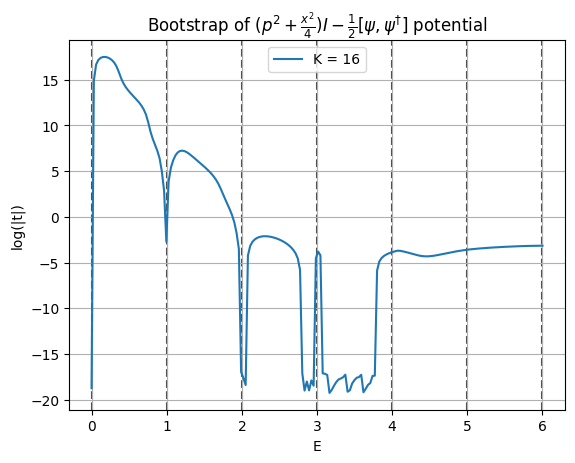

In [ ]:
# Plot exact energy eigenvalues
for E in spectrum:
    plt.axvline(x=E,ls='--',c='black',alpha=0.7,zorder=-2)

# data = np.load('x2pot_susy_k10_take2.npz',allow_pickle=True)
# sns.lineplot(x=data['Es'], y=np.log(np.fabs(data['ts'])),label='K = 10')
# data = np.load('x2pot_susy_k14.npz',allow_pickle=True)
# sns.lineplot(x=data['Es'], y=np.log(np.fabs(data['ts'])),label='K = 14')
data = np.load('x2pot_susy_k16_take2.npz',allow_pickle=True)
sns.lineplot(x=data['Es'], y=np.log(np.fabs(data['ts'])),label='K = 16')
plt.title(r'Bootstrap of $(p^2 + \frac{x^2}{4})I - \frac{1}{2}[\psi, \psi^{\dagger}]$ potential')
plt.xlabel('E')
plt.ylabel(r'log(|t|)')
# plt.xlim(-1,2)
# sns.despine()
plt.grid()
plt.legend()
plt.savefig('susy_x2.png',bbox_inches='tight')
plt.show()

In [142]:
A = np.array([0., 0., 0., 0., 0.25])
B = np.array([0., 1.])
K = 10
p2 = SUSYProblem(K, 'x4pot', A, B)
p2.initialize_problem()

In [143]:
Es = np.linspace(0, 8, num=266)
ts = solve(p2, Es)

In [139]:
xmin, xmax, N = -100, 100, 16384
spectrum1 = solveTISE(xmin, xmax, N, lambda x: x ** 4 / 4 - x, 10)

In [105]:
spectrum1

array([0.3541228 , 2.33663138, 4.64459062, 7.29401259])

In [144]:
np.savez(f'x4pot_susy_k{K}_take2',Es=Es,ts=ts)

In [146]:
print(dips[:-2])
print(dips[:-2:2])
print(dips[1:-2:2])
print(spectrum1)
print(np.diff(dips[:-2]))

[0.36226415 1.23773585 2.3245283  3.47169811 4.67924528 5.97735849]
[0.36226415 2.3245283  4.67924528]
[1.23773585 3.47169811 5.97735849]
[0.35411224 2.33657886 4.64442117 7.29362186]
[0.8754717  1.08679245 1.14716981 1.20754717 1.29811321]


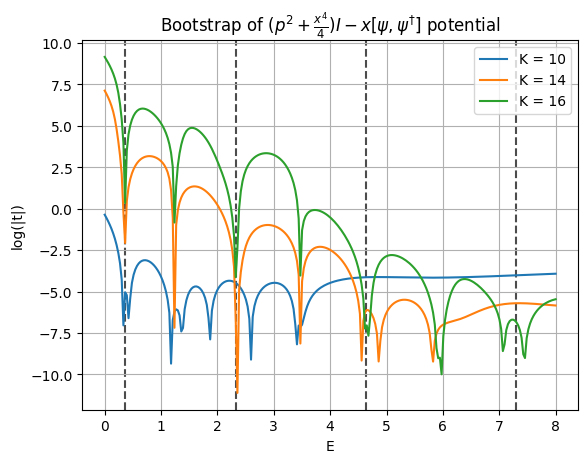

In [145]:
# Plot exact energy eigenvalues
for E in spectrum1:
    plt.axvline(x=E,ls='--',c='black',alpha=0.7,zorder=-2)

# print(dips)
# for dip in dips:
#     plt.axvline(x=dip,ls='--',c='red',alpha=0.7,zorder=-2)
data = np.load('x4pot_susy_k10_take2.npz',allow_pickle=True)
sns.lineplot(x=data['Es'], y=np.log(np.fabs(data['ts'])),label='K = 10')
data = np.load('x4pot_susy_k14_take2.npz',allow_pickle=True)
sns.lineplot(x=data['Es'], y=np.log(np.fabs(data['ts'])),label='K = 14')
data = np.load('x4pot_susy_k16_take2.npz',allow_pickle=True)
sns.lineplot(x=data['Es'], y=np.log(np.fabs(data['ts'])),label='K = 16')
peaks = find_peaks(-np.log(np.fabs(data['ts'])),prominence=1)[0]
dips = Es[peaks]
plt.title(r'Bootstrap of $(p^2 + \frac{x^4}{4})I - x[\psi, \psi^{\dagger}]$ potential')
plt.xlabel('E')
plt.ylabel(r'log(|t|)')
# plt.xlim(-1,2)
# sns.despine()
plt.grid()
plt.legend()
plt.savefig('susy_x2.png',bbox_inches='tight')
plt.show()

In [99]:
A = np.array([0., 0., 0., 0., 0., 0., 1/9])
B = np.array([0., 0., 1.])
K = 16
p2 = SUSYProblem(K, 'x6pot', A, B)
p2.initialize_problem()

In [100]:
Es = np.linspace(0, 6, num=200)
ts = solve(p2, Es)

In [101]:
xmin, xmax, N = -10, 10, 8192
spectrum1 = solveTISE(xmin, xmax, N, lambda x: x ** 6 / 9 - x ** 2, 6)

In [102]:
np.savez(f'x6pot_susy_k{K}_take2',Es=Es,ts=ts)

/tmp/ipykernel_15735/3241266504.py:10: RuntimeWarning: divide by zero encountered in log
  sns.lineplot(x=data['Es'], y=np.log(np.fabs(data['ts'])),label='K = 16')


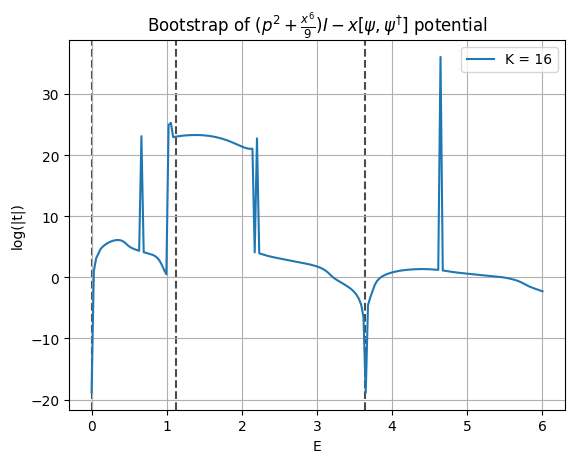

In [103]:
# Plot exact energy eigenvalues
for E in spectrum1:
    plt.axvline(x=E,ls='--',c='black',alpha=0.7,zorder=-2)

# data = np.load('x6pot_susy_k10_take2.npz',allow_pickle=True)
# sns.lineplot(x=data['Es'], y=np.log(np.fabs(data['ts'])),label='K = 10')
# data = np.load('x4pot_susy_k14.npz',allow_pickle=True)
# sns.lineplot(x=data['Es'], y=np.log(np.fabs(data['ts'])),label='K = 14')
data = np.load('x6pot_susy_k16_take2.npz',allow_pickle=True)
sns.lineplot(x=data['Es'], y=np.log(np.fabs(data['ts'])),label='K = 16')
plt.title(r'Bootstrap of $(p^2 + \frac{x^6}{9})I - x[\psi, \psi^{\dagger}]$ potential')
plt.xlabel('E')
plt.ylabel(r'log(|t|)')
# plt.xlim(-1,2)
# sns.despine()
plt.grid()
plt.legend()
plt.savefig('susy_x4.png',bbox_inches='tight')
plt.show()

In [7]:
class NonSUSYProblem(HankelProblem):
    """
    Solves H = p^2 + A(x).
    A(x) is a polynomial provided as a coefficient list.
    """
    def __init__(self, K, problem_name, A):
        super().__init__(K, problem_name)
        self._A = A
        self._dA = A.shape[0] - 1

    def _initialize_basis(self):
        self._basis = [None]
        self._basis[0] = [symbols(f'x^{i}') for i in range(2*self._K)]

    def _implement_recursion(self):
        # Normalization condition
        self._basis[0][0] = self._basis[0][0].subs({'x^0': mp.mpf('1')})

        # Recursion for <x>
        for t in range(1, len(self._basis[0]) - self._dA + 1):
            ti = mp.mpf(t)
            self._basis[0][t + self._dA - 1] = 4*ti*self._E*self._basis[0][t-1]
            if t >= 3:
                self._basis[0][t + self._dA - 1] += ti*(ti-1)*(ti-2)*self._basis[0][t-3]
            for n in range(self._dA):
                self._basis[0][t + self._dA - 1] -= (4*ti + 2*n)*self._A[n]*self._basis[0][t+n-1]
            self._basis[0][t + self._dA - 1] /= 2*self._A[-1]*(2*ti+self._dA)
    
    def _generate_internal_matrix_structure(self):
        self._internal_matrix = np.array([[None for _ in range(self._K)] for __ in range(self._K)]) #<x>
        for i in range(self._K):
            for j in range(self._K):
                self._internal_matrix[i, j] = self._basis[0][i + j]

In [30]:
A = np.array([0., 0., 0., 0., 0., 0., 1.])
K = 14
p2 = NonSUSYProblem(K, 'x6pot', A)
p2.initialize_problem()

In [31]:
Es = np.linspace(0, 20, num=600)
ts = solve(p2, Es)

In [66]:
xmin, xmax, N = -5, 5, 8192
spectrum = solveTISE(xmin, xmax, N, lambda x: x ** 6, 20)

In [33]:
np.savez(f'x6pot_qm_k{K}',Es=Es,ts=ts)

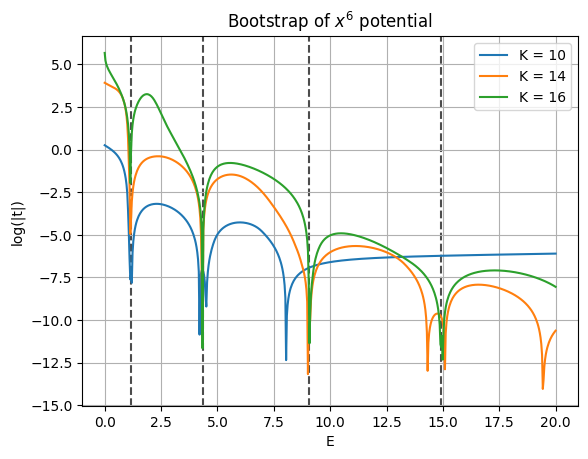

In [67]:
# Plot exact energy eigenvalues
for E in spectrum:
    plt.axvline(x=E,ls='--',c='black',alpha=0.7,zorder=-2)

data = np.load('x6pot_qm_k10.npz',allow_pickle=True)
sns.lineplot(x=data['Es'], y=np.log(np.fabs(data['ts'])),label='K = 10')
data = np.load('x6pot_qm_k14.npz',allow_pickle=True)
sns.lineplot(x=data['Es'], y=np.log(np.fabs(data['ts'])),label='K = 14')
data = np.load('x6pot_qm_k16.npz',allow_pickle=True)
sns.lineplot(x=data['Es'], y=np.log(np.fabs(data['ts'])),label='K = 16')
plt.title(r'Bootstrap of $x^6$ potential')
plt.xlabel('E')
plt.ylabel(r'log(|t|)')
# sns.despine()
plt.grid()
plt.legend()
plt.savefig('x6convergence.png',bbox_inches='tight')
plt.show()

In [61]:
# (x^2 - 1)^2
# x^4 -2x^2 + 1
A = np.array([1., 0., -2., 0., 1.])
K = 14
p2 = NonSUSYProblem(K, 'dwpot', A)
p2.initialize_problem()

In [62]:
Es = np.linspace(0, 6, num=200)
ts = solve(p2, Es)

In [68]:
xmin, xmax, N = -5, 5, 8192
spectrum = solveTISE(xmin, xmax, N, lambda x: (x ** 2 - 1) ** 2, 6)

In [63]:
np.savez(f'dwpot_qm_k{K}',Es=Es,ts=ts)

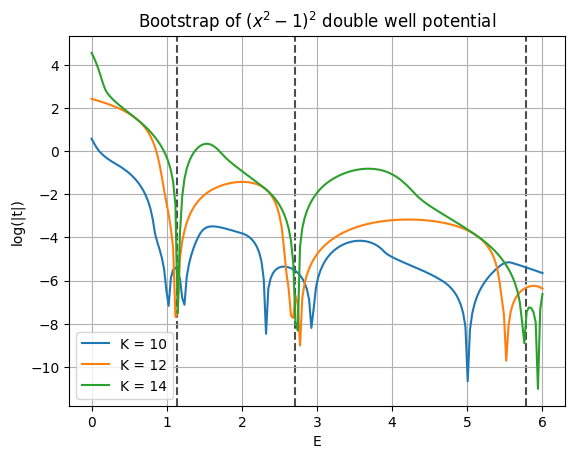

In [69]:
# Plot exact energy eigenvalues
for E in spectrum:
    plt.axvline(x=E,ls='--',c='black',alpha=0.7,zorder=-2)

data = np.load('dwpot_qm_k10.npz',allow_pickle=True)
sns.lineplot(x=data['Es'], y=np.log(np.fabs(data['ts'])),label='K = 10')
data = np.load('dwpot_qm_k12.npz',allow_pickle=True)
sns.lineplot(x=data['Es'], y=np.log(np.fabs(data['ts'])),label='K = 12')
data = np.load('dwpot_qm_k14.npz',allow_pickle=True)
sns.lineplot(x=data['Es'], y=np.log(np.fabs(data['ts'])),label='K = 14')
# data = np.load('x6pot_qm_k16.npz',allow_pickle=True)
# sns.lineplot(x=data['Es'], y=np.log(np.fabs(data['ts'])),label='K = 16')
plt.title(r'Bootstrap of $(x^2 - 1)^2$ double well potential')
plt.xlabel('E')
plt.ylabel(r'log(|t|)')
# sns.despine()
plt.grid()
plt.legend()
plt.savefig('dwconvergence.png',bbox_inches='tight')
plt.show()

In [11]:
class CosineProblem(HankelProblem):
    """
    Solves H = p^2 + cosx.
    """
    def _initialize_basis(self):
        self._basis = [None]
        self._basis[0] = [symbols(f'Ree^i{n}x') for n in range(2*self._K)]
        # self._basis[1] = [symbols(f'Ime^i{n}x') for n in range(2*self._K)]

    def _implement_recursion(self):
        # Normalization condition
        self._basis[0][0] = self._basis[0][0].subs({'Ree^i0x': mp.mpf('1')})
        # self._basis[1][0] = self._basis[1][0].subs({'Ime^i0x': mp.mpf('0')})
        # self._basis[1][1] = self._basis[1][1].subs({'Ime^i1x': mp.mpf('0')})

        # Recursion for <e^inx>
        for t in range(len(self._basis[0]) - 1):
            print(t)
            ti = mp.mpf(t)
            # ti = t
            # self._basis[0][t + 1] = -(ti/(ti + 2)) * self._basis[0][t-1] - (ti ** 3 /(ti + 2)) * self._basis[0][t] + 2 * self._E * (ti/(ti + 2)) * self._basis[0][t] + 2* self._E * self._basis[0][t]/(ti + 2)
            self._basis[0][t + 1] = (-ti ** 3 + 4 * self._E * ti)*self._basis[0][t]
            self._basis[0][t + 1] -= (2 * ti - 1) * self._basis[0][t - 1]
            self._basis[0][t + 1] /= (2 * ti + 1)
            # self._basis[1][t + 1] = -(ti/(ti + 2)) * self._basis[1][t-1] - (ti ** 3 /(ti + 2)) * self._basis[1][t] + 2 * self._E * (ti/(ti + 2)) * self._basis[1][t] + 2* self._E * self._basis[1][t]/(ti + 2)
            # self._basis[1][t + 1] = (-ti ** 3 + 4 * self._E * ti)*self._basis[1][t]
            # self._basis[1][t + 1] -= (2 * ti - 1) * self._basis[1][t - 1]
            # self._basis[1][t + 1] /= (2 * ti + 1)
    
    def _generate_internal_matrix_structure(self):
        R = np.array([[None for _ in range(self._K)] for __ in range(self._K)]) #<Ree^inx>
        # C = np.array([[None for _ in range(self._K)] for __ in range(self._K)]) #<Ime^inx>
        # C = np.zeros_like(R)
        # [[R, -C]
        # [C, R]]
        for i in range(self._K):
            for j in range(self._K):
                print(i, j)
                R[i, j] = self._basis[0][np.abs(j - i)]
                # C[i, j] = np.sign(j - i) * self._basis[1][np.abs(j - i)]
        self._internal_matrix = R
        # self._internal_matrix = np.block([[R, -C],
                                        #   [C, R]])

In [89]:
xmin, xmax, N = -1000, 1000, 8192
spectrum1 = solveTISE(xmin, xmax, N, np.cos, 6)

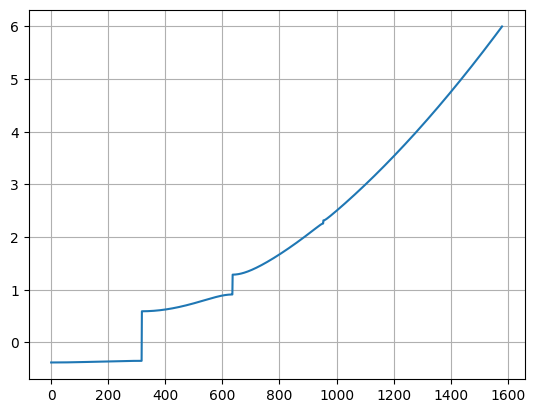

In [90]:
plt.plot(spectrum1)
plt.grid()

In [136]:
p2 = CosineProblem(16, 'cospot')
p2.initialize_problem()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
7 12
7 13
7 14
7 15
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
8 13
8 14
8 15
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
9 12
9 13
9 14
9 15
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
10 12
10 13
10 14
10 15
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
11 11
11 12
11 13
11 14
11 15
12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8


In [15]:
Es = np.linspace(0, 6, num=200)

In [137]:
p2._freevars

[Ree^i31x]

In [138]:
ts = solve(p2, Es)

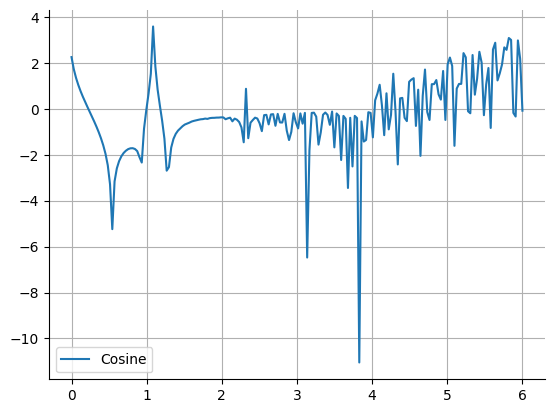

In [139]:
sns.lineplot(x=Es, y=np.log(np.fabs(ts)), label='Cosine')
# plt.scatter(spectrum1,np.ones_like(spectrum1))
sns.despine()
plt.grid()
plt.legend()
plt.show()

In [28]:
A = np.array([0., 0., 0.1, 0., 0., 0., 1/9])
B = np.array([0., 0., 1.])
p = SUSYProblem(16, 'x6pot', A, B)
p.initialize_problem()

In [29]:
ts1 = solve(p, Es)

In [23]:
def W2(x):
    return 0.1 * x**2 + x ** 6 / 9
def Wdiff(x):
    return x ** 2
xmin, xmax, N = -5, 5, 1024
spectrum = solveSUSYTISE(xmin, xmax, N, W2, Wdiff, 6)

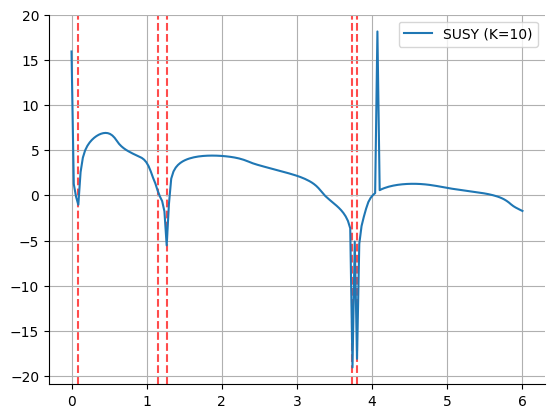

In [30]:
# Plot exact energy eigenvalues
for E in spectrum:
    plt.axvline(x=E,ls='--',c='red',alpha=0.7,zorder=-2)

sns.lineplot(x=Es, y=np.log(np.fabs(ts1)), label='SUSY (K=10)')
sns.despine()
plt.grid()
plt.legend()
plt.show()

In [40]:
A = np.array([-0.5, 0., 0.25, 0., 0.1])
p2 = NonSUSYProblem(20, 'x4pot', A)
p2.initialize_problem()

In [41]:
ts2 = solve(p2, Es)

In [35]:
g = 0.1
def W2(x):
    return x ** 2 / 4 + g * x ** 4
def Wdiff(x):
    return 1 / 2
def pot1(x):
    return W2(x) - Wdiff(x)
def pot2(x):
    return W2(x) + Wdiff(x)
xmin, xmax, N = -5, 5, 1024
spectrum1 = solveTISE(xmin, xmax, N, pot1, 6)
spectrum2 = solveTISE(xmin, xmax, N, pot2, 6)
spectrum3 = solveSUSYTISE(xmin, xmax, N, W2, Wdiff, 6)

In [36]:
print(spectrum1)
print(spectrum2)
print(spectrum3)

[0.16876913 1.71690306 3.602766   5.71542656]
[1.16876913 2.71690306 4.602766  ]
[0.16876913 1.16876913 1.71690306 2.71690306 3.602766   4.602766
 5.71542656]


/tmp/ipykernel_730/315547476.py:5: RuntimeWarning: divide by zero encountered in log
  sns.lineplot(x=Es, y=np.log(np.fabs(ts1)), label='SUSY (K=16)')


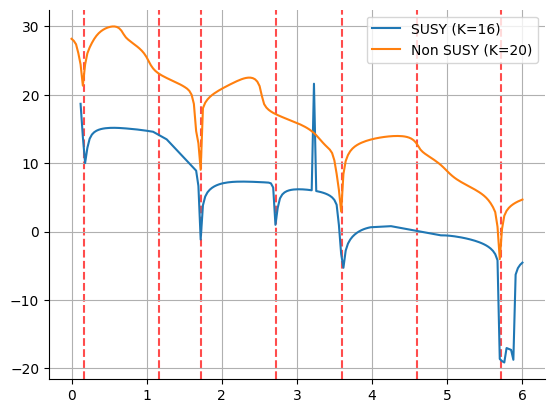

In [48]:
# Plot exact energy eigenvalues
for E in spectrum3:
    plt.axvline(x=E,ls='--',c='red',alpha=0.7,zorder=-2)

sns.lineplot(x=Es, y=np.log(np.fabs(ts1)), label='SUSY (K=16)')
sns.lineplot(x=Es, y=np.log(np.fabs(ts2)), label='Non SUSY (K=20)')
# peaks = find_peaks(-np.log(np.fabs(ts)),prominence=1)[0]
# dips = Es[peaks]
# print(dips)
# for dip in dips:
#     plt.axvline(x=dip,ls='--',c='grey',alpha=0.7,zorder=-2)
sns.despine()
plt.grid()
plt.legend()
plt.show()

In [137]:
t = p.solve(1.5)

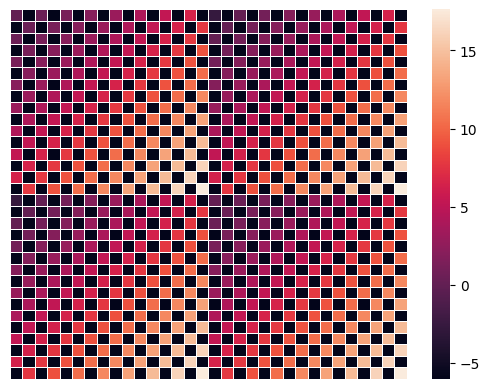

In [138]:
s = []
K = 16
with open('aho.result','r') as rfile:
    lines = rfile.readlines()
    for lpos, line in enumerate(lines):
        if line.startswith('xMat'):
            for i in range(2*K-1):
                s.append(np.double(lines[lpos+2+i][3:-4].split(',')))
            s.append(np.double(lines[lpos+2+2*K-1][3:-7].split(',')))
            s=np.array(s)
            break
s -= np.eye(2*K)*t
ax = sns.heatmap(np.log10(1e-6+np.abs(s)), linewidth=0.5)
plt.xticks(ticks=[], labels=[])
plt.yticks(ticks=[], labels=[])
plt.show()

In [141]:
t = p2.solve(0.99497487)

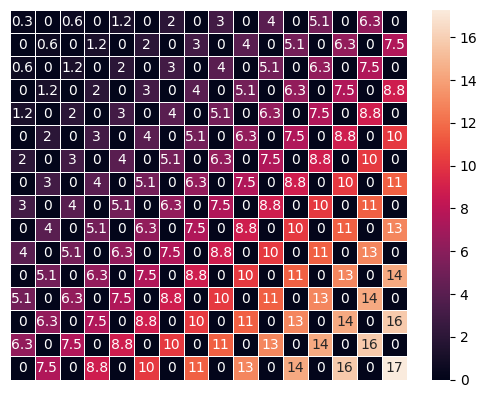

In [144]:
s = []
K = 16
with open('aho.result','r') as rfile:
    lines = rfile.readlines()
    for lpos, line in enumerate(lines):
        if line.startswith('xMat'):
            for i in range(K-1):
                s.append(np.double(lines[lpos+2+i][3:-4].split(',')))
            s.append(np.double(lines[lpos+2+K-1][3:-7].split(',')))
            s=np.array(s)
            break
s -= np.eye(K)*t
ax = sns.heatmap(np.log10(1+np.abs(s)), linewidth=0.5, annot=True)
plt.xticks(ticks=[], labels=[])
plt.yticks(ticks=[], labels=[])
plt.show()

<hr>